## Plot the mask we copied from Ben Barton and see how this relates to our work

In [1]:
# import packages and functions
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

import h5py
from scipy.io import loadmat
from scipy.io import savemat

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.colors import ListedColormap as ListedColormap

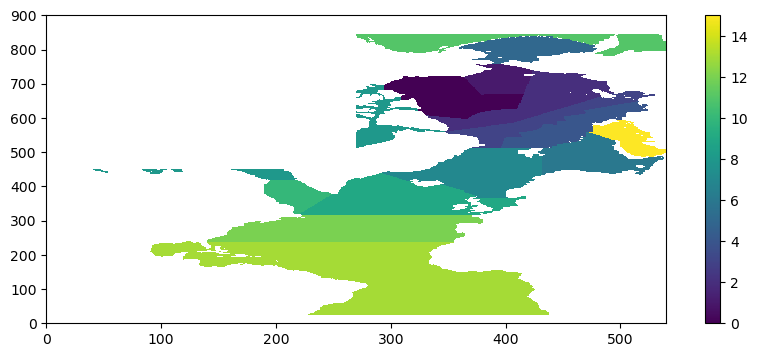

In [3]:
# load the whole Basin mask
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [4]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [5]:
barton_mask = np.load("poly_mask.npy")

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [6]:
barton_mask[barton_mask == 0] = np.nan

## get the sea ice edge

In [7]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
# allyears = np.arange(2003,2018,1)

In [8]:
allyears = np.array([2007,2016])

In [9]:
# define the sea ice extent for March

# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),3,ny,nx))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 

    # loop through JFM for this year
    for m in range(3):
        march_tsstr = tsstr[m]
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])

    
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        read = int(tsstr[2])  # march
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea    
        SIareas[iy,m] = SIarea

    iy += 1

2007
2016


In [10]:
SIareas.shape
np.nanmean(SIareas[0], axis=0).shape

(1350, 270)

In [11]:
# define the ice edge to plot
SI_early_tr = get_aste_tracer(np.nanmean(SIareas[0], axis=0),nfx,nfy)[0]     # monthly average for first year
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[1], axis=0),nfx,nfy)[0]      # monthly JFM average for second year

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

# get the SST = 2 degree contour from avg temperature field

In [12]:
times = {}
times["2007"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

times = {}
times["2016"] = np.arange(1,13,1)   # write all the months for this example 5-year period
tsstr2,datetimes2 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

In [13]:
THETA = np.zeros((len(tsstr)+len(tsstr2),nz,ny,nx))
# tsstr.shape

In [14]:
# load the SST for the two years -- FIX

# do sea ice area, SST, SSS reading the files
# read in the surface salt flux values

#all 2007
for t in range(len(tsstr)):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t] = THETAi

#all 2016
for t in range(len(tsstr2[:-1])):
    file_name = 'state_3d_set1'
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    t2 = int(tsstr2[t])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETAi,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    THETAi = THETAi.reshape(nz,ny,nx)

    # set in the larger array
    THETA[t+12] = THETAi

# do the time averaging
THETA1 = np.nanmean(THETA[:12],axis=0) #* hfC
THETA2 = np.nanmean(THETA[12:],axis=0) #* hfC

In [15]:
SST1 = THETA1[0]
SST2 = THETA2[0]

## plot a big map so we can look at this

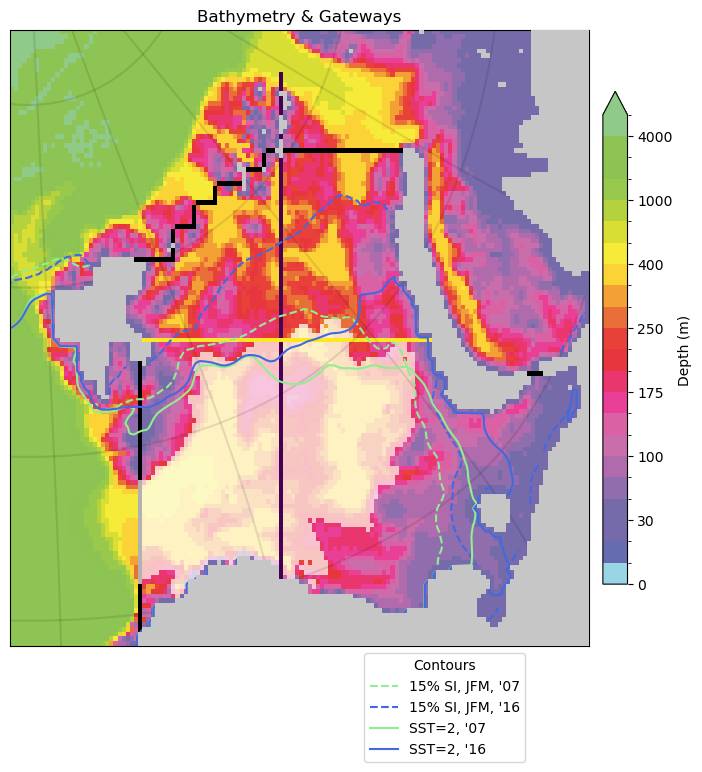

In [16]:
# plot both of these to look at where this is
# --- Bathymetry Colormap ---
colors = ['#7fcce0', '#3f479b', '#544596', '#534694', '#754898', '#9b4696', '#bd4896',
          '#d13b8d', '#e50f7c', '#e4034b', '#e3030e', '#e11108', '#e34b05', '#f18901',
          '#fcc903', '#f5e707', '#cfd600', '#a2c60e', '#7ebc20', '#6fb528', '#72b628', '#74bd6b']
bounds = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
          400, 500, 750, 1000, 1500, 2000, 4000, 6000]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

land_data = get_aste_tracer(landmsk, nfx, nfy)[0]
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

# --- Figure Setup ---
fig, ax0 = plt.subplots(figsize=(9, 8))

# ========== Bathymetry ==========
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=7, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen',
            linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue',
            linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
# ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap=black_cmap,
#                zorder=2, vmin=0.5, vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8, pad=0.02,
                   boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)

# add the mask we did for Barton
ax0.pcolormesh(get_aste_tracer(barton_mask,nfx,nfy)[0],cmap="Greys",alpha=0.7)


# add the cross-sectional terms (may use later)
y_sample = np.arange(435,551,1)
x_sample = np.full(y_sample.shape,465)
x_cross = np.arange(430,505,1)
y_cross = np.full(x_cross.shape,494)
sample_cross = np.full((900,540),np.nan)
sample_cross[y_sample,x_sample]= 1
sample_cross[y_cross,x_cross]= 3
sample_cross = aste_tracer2compact(sample_cross,nfx,nfy)[0]
plt.pcolormesh(get_aste_tracer(sample_cross,nfx,nfy)[0])


# plot the avg winter sea ice extent for the two layers years (2007 and 2016)
cs1 = ax0.contour(get_aste_tracer(SST1, nfx, nfy)[0], levels=[2], colors="lightgreen", linestyles="-", linewidths=1.5)
cs2 = ax0.contour(get_aste_tracer(SST2, nfx, nfy)[0], levels=[2], colors="royalblue", linestyles="-", linewidths=1.5)

# Legend for the JFM sea ice extent
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '16"),
    Line2D([0], [0], color='lightgreen', linestyle='-', linewidth=1.5,
           label="SST=2 '07"),
    Line2D([0], [0], color='royalblue', linestyle='-', linewidth=1.5,
           label="SST=2, '16"),
]

labels = [
    "15% SI, JFM, '07",
    "15% SI, JFM, '16",
    "SST=2, '07",
    "SST=2, '16"
]

ax0.legend(handles=legend_elements, labels=labels, loc='lower left',
           bbox_to_anchor=(.6, -.2), fontsize=10,
           frameon=True, title='Contours')

# plot the avg contour for surface 2-deg C for the two layers years

plt.show()

# I think we want to compare both the WMT within the Barton box and North of it for each of the two years

## load the layers output which we generated for 2007 within the Barton box

In [17]:
# I think what we should try to do is fully delve into this and decide what is happening differently in this box

# neither year will have much interaction with the sea ice

# I think it will be faster to do this without layers and just use the regular ASTE
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2007"] = np.arange(1,13,1)
times["2008"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

AB_gT=0
AB_gS=0

tsteps = len(datetimes)-1
tsteps

12

In [18]:
# set the mask we want to use
mymsk = barton_mask
iB = 6 # redundant, but we use for the Barents Sea
titlestr = "AW contrib region "  # for plotting so we know and save correctly

In [19]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all_2007 = np.zeros((tsteps,nS,nT))
JtermsT_all_2007 = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all_2007 = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all_2007 = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all_2007 = np.zeros((tsteps,5,nS,nT))

vol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

In [20]:
dstart = 10
dterm = 50      # for below 100 m
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn,a,b = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms,dstart,dterm)

    vol_mesh_all_2007[i] = vol_mesh
    JtermsT_all_2007[i] = JtermsT
    JtermsS_all_2007[i] = JtermsS
    JtermsT_nn_all_2007[i] = JtermsT_nn
    JtermsS_nn_all_2007[i] = JtermsS_nn

2007-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -1.097931543180301e-13 Sv/PSU
doing JtermsS
total residual 3.0766741998327577e-13 Sv/degC
doing not normalized J terms
total residual -1.097931543180301e-13 Sv
total residual 3.0766741998327577e-13 Sv
2007-02-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 2.727541703237933e-13 Sv/PSU
doing JtermsS
total residual 2.172139884915922e-12 Sv/degC
doing not normalized J terms
total residual 2.727541703237933e-13 Sv
total residual 2.172139884915922e-12 Sv
2007-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 1.3390569628465984e-13 Sv/PSU
doing JtermsS
total residual 7.767841345946664e-13 Sv/degC
doing not normalized J terms
total residual 1.3390569628465984e-13 Sv
total residual 7.

In [21]:
# can I also create the 2016 budget here? not sure if memory available
nS,nT = 112,112
vol_mesh_all_2016 = np.zeros((tsteps,nS,nT))
JtermsT_all_2016 = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all_2016 = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all_2016 = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all_2016 = np.zeros((tsteps,5,nS,nT))

In [22]:
times = {}
times["2016"] = np.arange(1,13,1)
times["2017"] = np.array([1])

# the filenames we want for 2014
tsstr16,datetimes16 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

for i in range(len(datetimes16)-1):
    print(datetimes16[i])
    tsstrhere = tsstr16[i:i+2]
    datetimeshere = datetimes16[i:i+2]
    dt = datetimes16[i+1]-datetimes16[i]
    dt = dt.total_seconds()
    t2 = int(tsstr16[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn,a,b = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms,dstart,dterm)

    vol_mesh_all_2016[i] = vol_mesh
    JtermsT_all_2016[i] = JtermsT
    JtermsS_all_2016[i] = JtermsS
    JtermsT_nn_all_2016[i] = JtermsT_nn
    JtermsS_nn_all_2016[i] = JtermsS_nn

2016-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -7.668651560899969e-14 Sv/PSU
doing JtermsS
total residual -9.304862924001261e-13 Sv/degC
doing not normalized J terms
total residual -7.668651560899969e-14 Sv
total residual -9.304862924001261e-13 Sv
2016-02-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 2.0346452387492997e-13 Sv/PSU
doing JtermsS
total residual -8.067092577035721e-13 Sv/degC
doing not normalized J terms
total residual 2.0346452387492997e-13 Sv
total residual -8.067092577035721e-13 Sv
2016-03-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 4.516036795822881e-14 Sv/PSU
doing JtermsS
total residual -1.5631662241330892e-12 Sv/degC
doing not normalized J terms
total residual 4.516036795822881e-14 Sv
total residua

In [23]:
# save these as npy arrays so we can use later

# --- Save arrays as .npy ---
# np.save("vol_mesh_all_2007.npy", vol_mesh_all_2007)
# np.save("JtermsT_all_2007.npy", JtermsT_all_2007)
# np.save("JtermsS_all_2007.npy", JtermsS_all_2007)
# np.save("JtermsT_nn_all_2007.npy", JtermsT_nn_all_2007)
# np.save("JtermsS_nn_all_2007.npy", JtermsS_nn_all_2007)

# np.save("vol_mesh_all_2016.npy", vol_mesh_all_2016)
# np.save("JtermsT_all_2016.npy", JtermsT_all_2016)
# np.save("JtermsS_all_2016.npy", JtermsS_all_2016)
# np.save("JtermsT_nn_all_2016.npy", JtermsT_nn_all_2016)
# np.save("JtermsS_nn_all_2016.npy", JtermsS_nn_all_2016)

# --- Load arrays back ---
# vol_mesh_all_2007 = np.load("vol_mesh_all_2007.npy")
# JtermsT_all_2007 = np.load("JtermsT_all_2007.npy")
# JtermsS_all_2007 = np.load("JtermsS_all_2007.npy")
# JtermsT_nn_all_2007 = np.load("JtermsT_nn_all_2007.npy")
# JtermsS_nn_all_2007 = np.load("JtermsS_nn_all_2007.npy")

# vol_mesh_all_2016 = np.load("vol_mesh_all_2016.npy")
# JtermsT_all_2016 = np.load("JtermsT_all_2016.npy")
# JtermsS_all_2016 = np.load("JtermsS_all_2016.npy")
# JtermsT_nn_all_2016 = np.load("JtermsT_nn_all_2016.npy")
# JtermsS_nn_all_2016 = np.load("JtermsS_nn_all_2016.npy")

## Overview of WMT differences for these two

In [24]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [25]:
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [26]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


In [27]:
# calculate the differences in the J terms for the two years
JtermsT = JtermsT_all_2016 - JtermsT_all_2007
JtermsS = JtermsS_all_2016 - JtermsS_all_2007
JtermsT = np.nanmean(JtermsT,axis=0)
JtermsS = np.nanmean(JtermsS,axis=0)

In [28]:
# load the timeseries of the gates themselves
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2007.npy", allow_pickle=True).item()

heat_transport_timeseries07 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries07 = loaded_data["salt_transport_timeseries"]
theta_timeseries07 = loaded_data["theta_timeseries"]
salt_timeseries07 = loaded_data["salt_timeseries"]
binned_theta_timeseries07 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries07 = loaded_data["binned_salt_timeseries"]

# load the gateway transports for 2016
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_2016.npy", allow_pickle=True).item()

heat_transport_timeseries16 = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries16 = loaded_data["salt_transport_timeseries"]
theta_timeseries16 = loaded_data["theta_timeseries"]
salt_timeseries16 = loaded_data["salt_timeseries"]
binned_theta_timeseries16 = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries16 = loaded_data["binned_salt_timeseries"]

## Also plot the gate TS diagram differences for these

In [30]:
# compute the gate transports

# now to try and show that this gate convergence fits with previous solution
def m_TS_from_prebinned(heat_tr, salt_tr, iT, iS, Tcent, Scent, binwidthT, binwidthS,
                        T_min=1e-3, S_min=1e-4):
    """
    Inputs:
      heat_tr : (nz, nfaces)  degC·m^3/s  (T*Q)
      salt_tr : (nz, nfaces)  psu·m^3/s   (S*Q)
      iT, iS  : (nz, nfaces)  integer bin indices in [0..nT-1],[0..nS-1]
      Tcent   : (nT,)         bin centers (degC)
      Scent   : (nS,)         bin centers (psu)
    Output:
      m_TS    : (nS, nT)      Sv/(psu·°C)
    """
    nT = len(Tcent); nS = len(Scent)
    m_TS = np.zeros((nS-1, nT-1), dtype=float)

    # Flatten
    HT  = heat_tr.reshape(-1)              # degC·m^3/s
    ST  = salt_tr.reshape(-1)              # psu·m^3/s
    iTf = iT.reshape(-1).astype(int)
    iSf = iS.reshape(-1).astype(int)

    # Valid bins
    valid = (iTf >= 0) & (iTf < nT) & (iSf >= 0) & (iSf < nS)
    if not np.any(valid):
        return m_TS

    iTv = iTf[valid]; iSv = iSf[valid]
    HTv = HT[valid];  STv = ST[valid]

    # Get bin-center T,S for those indices
    Tv = Tcent[iTv]; Sv = Scent[iSv]

    # Recover Q (m^3/s). Prefer salt (often better conditioned), fallback to heat.
    Qs = np.where(np.abs(Sv) > S_min, STv / Sv, np.nan)
    Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
    Q  = np.where(np.isfinite(Qs), Qs, Qt)
    Q  = np.where(np.isfinite(Q), Q, 0.0)   # m^3/s (+ into basin)

    # Convert to Sv and normalize by ΔS·ΔT → Sv/(psu·°C)
    dSv = binwidthS[iSv]; dTv = binwidthT[iTv]
    contrib = (Q * 1e-6) / (dSv * dTv)

    np.add.at(m_TS, (iSv, iTv), contrib)
    return m_TS


# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [32]:
def m_TS_total_from_timeseries(
    heat_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    salt_ts_by_gate,          # dict: gate -> array [nyears, 12, nz, nfaces]
    iT_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    iS_ts_by_gate,            # dict: gate -> array [nyears, 12, nz, nfaces] (ints)
    Tcent, Scent,             # bin centers
    binwidthT, binwidthS,     # bin widths
    year_idx,
    months=None,              # list of month indices to average (e.g., [0,1,2]); if None, uses all 12
    gates=("BSO","SFJ","FJNZ","NZRU"),
    reducer="mean"            # "mean" or "sum" across selected months
):
    """
    Build m_TS_total (Sv/(psu·°C)) by:
      1) computing m_TS_from_prebinned per month per gate,
      2) averaging (or summing) across the selected months per gate,
      3) summing across gates.

    Parameters
    ----------
    heat_ts_by_gate, salt_ts_by_gate, iT_ts_by_gate, iS_ts_by_gate : dict[str, np.ndarray]
        Each maps gate -> array shaped [nyear, 12, nz, nfaces] (int types for iT/iS).
    Tcent, Scent : 1D arrays
        Bin centers for T and S.
    binwidthT, binwidthS : 1D arrays
        Bin widths for T and S. Assumes `m_TS_from_prebinned` expects these.
    year_idx : int
        Index into the 'year' dimension of the timeseries arrays.
    months : list[int] | None
        0-based month indices to average. If None, uses range(12).
    gates : iterable[str]
        Gates to include.
    reducer : {"mean", "sum"}
        How to combine over months (default "mean").

    Returns
    -------
    m_TS_total : 2D np.ndarray
        Seasonal-aggregated m_TS summed over the provided gates, units Sv/(psu·°C).
    """
    if months is None:
        months = list(range(12))
    # sanity-check month indices
    months = [int(m) for m in months]
    if any((m < 0 or m > 11) for m in months):
        raise ValueError(f"Month indices must be in [0,11]; got {months}")

    # Helper to combine across months
    def _combine(stack, reducer):
        if reducer == "mean":
            return np.nanmean(stack, axis=0)
        elif reducer == "sum":
            return np.nansum(stack, axis=0)
        else:
            raise ValueError(f"Unknown reducer: {reducer}")

    m_by_gate = {}

    for g in gates:
        m_list = []
        for m in months:
            HT = heat_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            ST = salt_ts_by_gate[g][year_idx, m]  # (nz, nfaces)
            iT = iT_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints
            iS = iS_ts_by_gate[g][year_idx, m]    # (nz, nfaces) ints

            # User-provided function: returns m_TS on (S,T) bins, units Sv/(psu·°C)
            m_gate_month = m_TS_from_prebinned(HT, ST, iT, iS, Tcent, Scent, binwidthT, binwidthS)
            m_list.append(m_gate_month)

        # average (or sum) across selected months for this gate
        m_by_gate[g] = _combine(np.stack(m_list, axis=0), reducer)

    # sum over gates to get the total
    m_TS_total = np.sum([m_by_gate[g] for g in gates], axis=0)
    return m_TS_total


months_all = list(range(12))
m_TS_total_2007 = m_TS_total_from_timeseries(
    heat_transport_timeseries07,
    salt_transport_timeseries07,
    binned_theta_timeseries07,
    binned_salt_timeseries07,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_all,
    gates=(["BSO"]),
    reducer="mean"
)

m_TS_total_2016 = m_TS_total_from_timeseries(
    heat_transport_timeseries16,
    salt_transport_timeseries16,
    binned_theta_timeseries16,
    binned_salt_timeseries16,
    Tcent, Scent, binwidthT, binwidthS,
    year_idx=0,
    months=months_all,
    gates=(["BSO"]),
    reducer="mean"
)


In [36]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
print(nT)

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
print(nS)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
print(binwidthT.shape)
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

112
112
(112,)


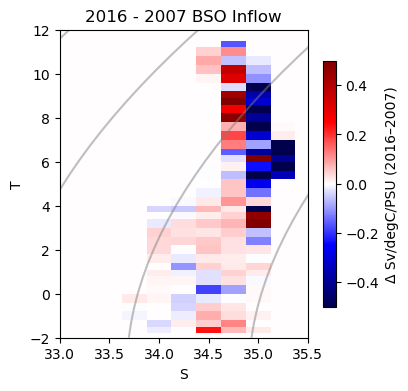

In [47]:
fig = plt.figure(figsize = (4,4))
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)
ax1 = plt.subplot(111)
vlev = 0.5
im1 = ax1.pcolormesh(Sbin2, Tbin2, m_TS_total_2016 - m_TS_total_2007, cmap="seismic", vmin=-vlev, vmax=vlev)
cs = ax1.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
ax1.clabel(cs, fontsize=9, inline=False, fmt="%.0f")
ax1.set_xlim(33, 35.5)
ax1.set_ylim(-2, 12)
ax1.set_title("2016 - 2007 BSO Inflow")
ax1.set_xlabel("S")
ax1.set_ylabel("T")

# add colorbar
cbar = fig.colorbar(im1, ax=ax1, orientation="vertical", shrink=0.8)
cbar.set_label("Δ Sv/degC/PSU (2016–2007)")

In [48]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        #print(y_idx)
        for depth in range(nz):
            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx]
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx]

    iy += 1  # Move to the next year


Processing year: 2007
Processing year: 2016


In [49]:
# calculate the inflow T and S so we can look at these
# Compute distances dynamically for each gate
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

# let's figure out which indices we want by the location along the gate
# gate_distances['BSO'][21:35]
# let's also do the depth below the surface (k = 10+)  this will be 100m+
# can possibly just do a scatter plot of these inflow values
AWinflow = np.where((gate_distances['BSO'] < 565) & (gate_distances['BSO'] > 335))
a,b = AWinflow[0][0],AWinflow[0][-1]
d_sel = np.where(np.cumsum(mygrid['DRF']) > 110)
d_sel = d_sel[0][0]   # this should be the same as we did for the WMT d terms

In [52]:
dlabel = np.cumsum(mygrid['DRF'])[dstart]
dlabel

110.47

Saved seasonal convergence difference figures with volume contours: ['./convergence_diff_deep_JFM_2x3.png', './convergence_diff_deep_AMJ_2x3.png', './convergence_diff_deep_JAS_2x3.png', './convergence_diff_deep_OND_2x3.png']


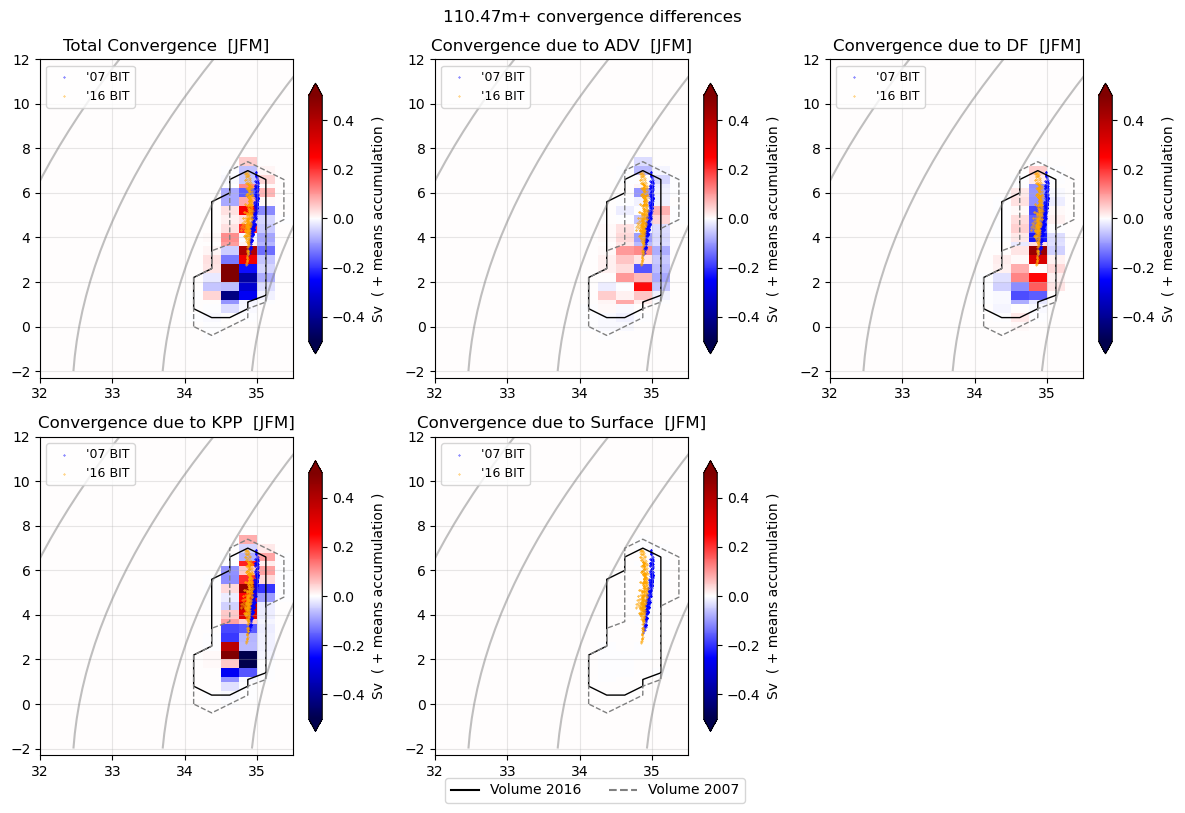

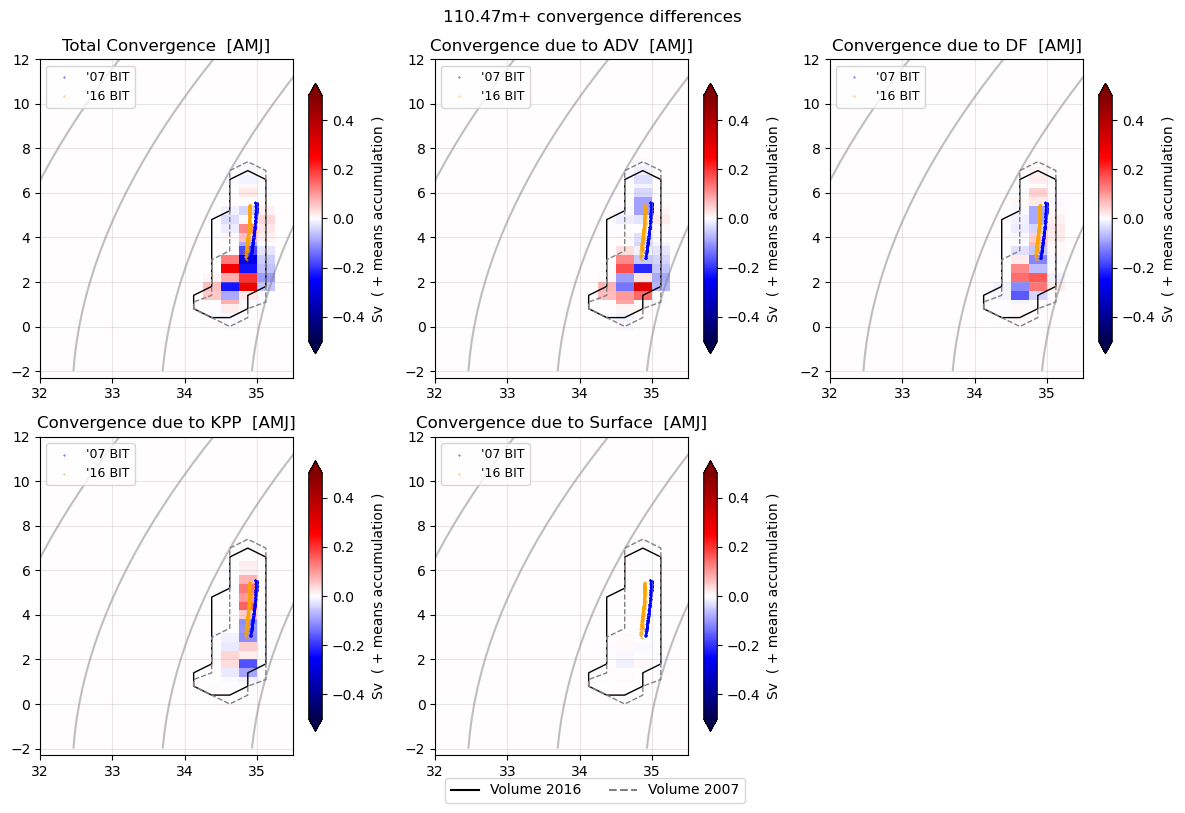

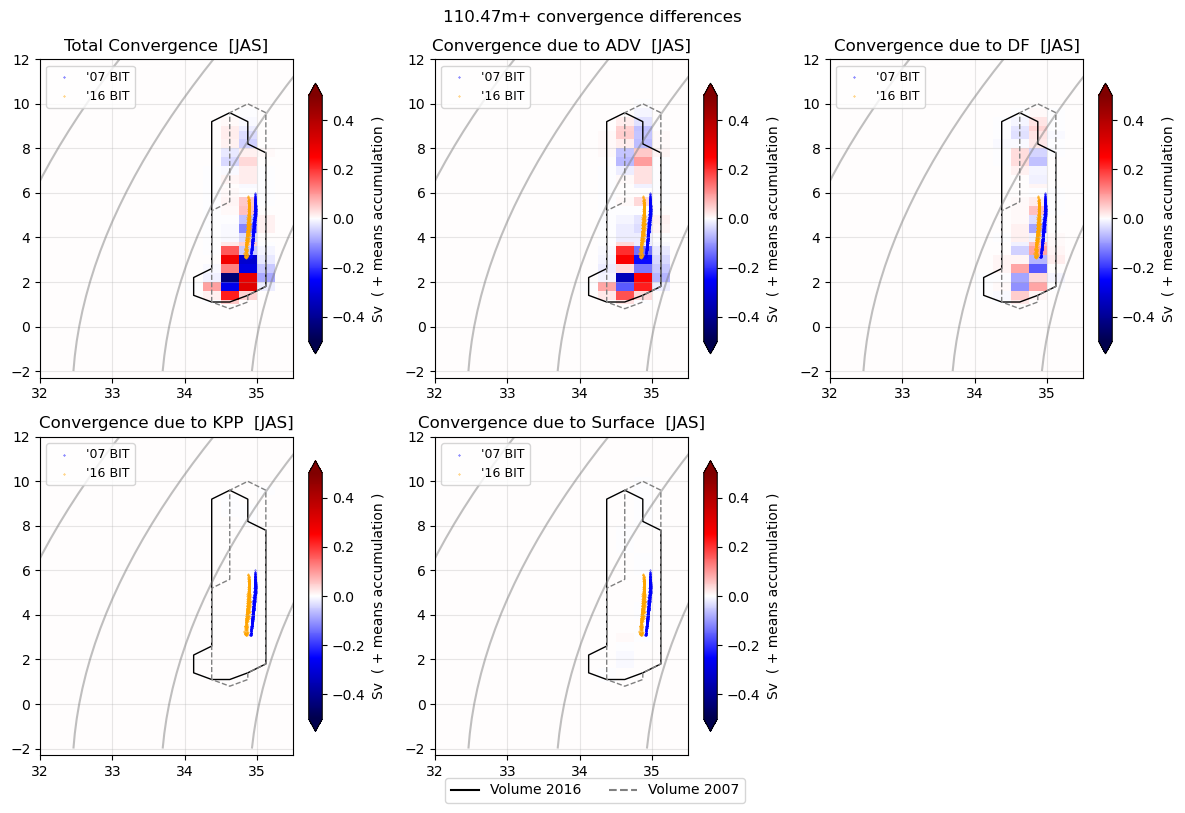

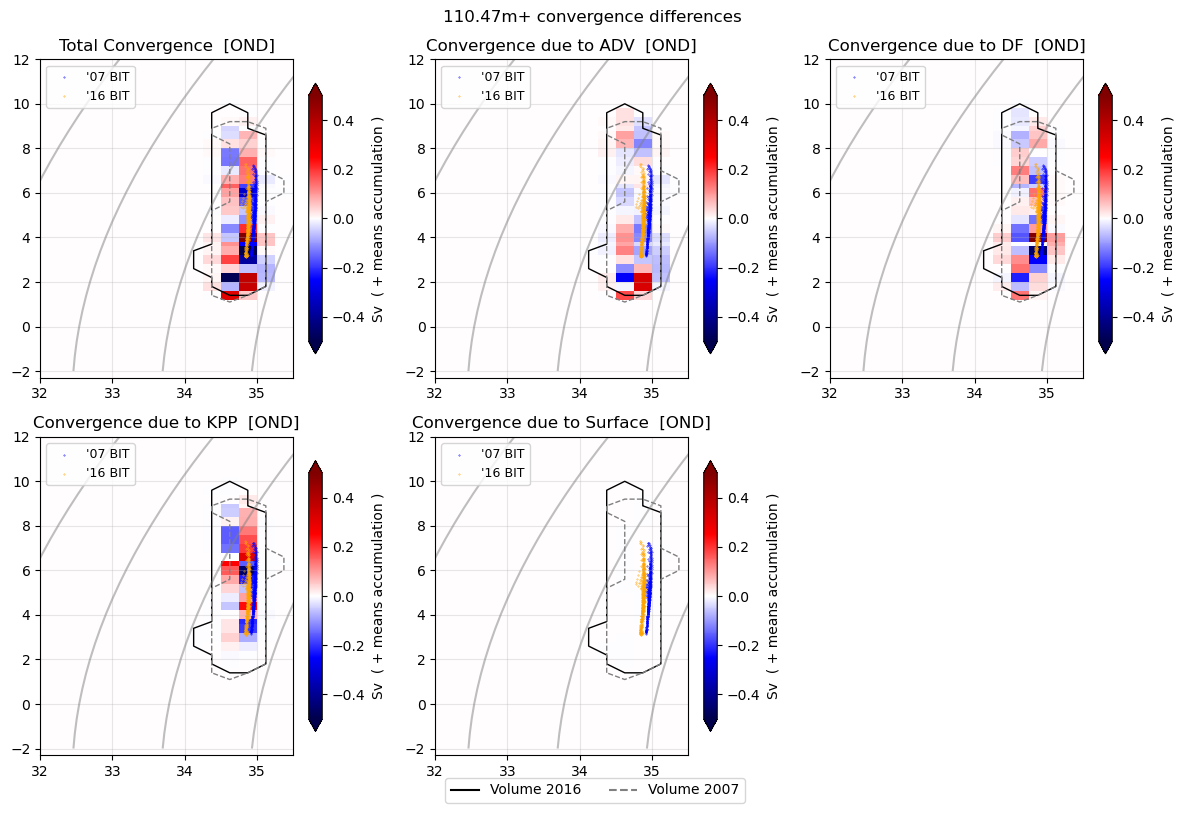

In [53]:
# THIS ONE HAS THE OUTLINES OF THE OTHER VOLUME FOR THIS REGION

# ---- inputs assumed to exist ----
# JtermsS_nn_all_2016, JtermsS_nn_all_2007: (tsteps, 5, nS, nT)
# JtermsT_nn_all_2016, JtermsT_nn_all_2007: (tsteps, 5, nS, nT)
# vol_mesh_all_2016, vol_mesh_all_2007: (tsteps, nS, nT)
# Sbin, Tbin: 1D bin centers (match nS, nT for pcolormesh)
# si, ti, dens2: density contour grids
# path (optional): output directory string
# ----------------------------------------------------

xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 12])
vlev = 0.5  # symmetric color scale half-range

titles = [
    "Total Convergence", "Convergence due to ADV", "Convergence due to DF",
    "Convergence due to KPP", "Convergence due to Surface"
]

# seasonal groups (0-based timestep indices)
seasons = {
    "JFM": [0, 1, 2],
    "AMJ": [3, 4, 5],
    "JAS": [6, 7, 8],
    "OND": [9,10,11],
}

outdir = locals().get("path", ".")  # use 'path' if defined

# Choose contour levels by percentiles of volume (relative contours)
vol_percentile_levels = [50, 75, 90]  # median, upper quartiles
# If you prefer fixed fractions of max, use e.g. rel_levels = [0.2, 0.4, 0.6, 0.8]

for sname, idxs in seasons.items():
    # --- seasonal means ---
    # Flux terms (shape: (5, nS, nT))
    JS16 = np.nanmean(JtermsS_nn_all_2016[idxs, ...], axis=0)
    JT16 = np.nanmean(JtermsT_nn_all_2016[idxs, ...], axis=0)
    JS07 = np.nanmean(JtermsS_nn_all_2007[idxs, ...], axis=0)
    JT07 = np.nanmean(JtermsT_nn_all_2007[idxs, ...], axis=0)

    # Volume fields (shape: (nS, nT))
    VOL16 = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)
    VOL07 = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

    # Compute percentile-based contour levels for each year (robust to scaling)
    # Mask negatives if any (volumes should be >=0)
    VOL16_pos = np.where(np.isfinite(VOL16) & (VOL16 > 0), VOL16, np.nan)
    VOL07_pos = np.where(np.isfinite(VOL07) & (VOL07 > 0), VOL07, np.nan)

    # If everything is NaN, fall back to zeros to avoid errors
    if np.all(~np.isfinite(VOL16_pos)): VOL16_pos = np.zeros_like(VOL16)
    if np.all(~np.isfinite(VOL07_pos)): VOL07_pos = np.zeros_like(VOL07)

    levels16 = np.nanpercentile(VOL16_pos, vol_percentile_levels)
    levels07 = np.nanpercentile(VOL07_pos, vol_percentile_levels)

    # calculate the scatter from the gates at each of the timesteps
    thetas = theta_timeseries['BSO'][:,idxs,:,:]   # theta for JFM
    salts = salt_timeseries['BSO'][:,idxs,:,:]
    
    theta_07_sample = thetas[0,:,d_sel:,a:b]  # select theta for this time; JFM, depth term, length along gate
    salt_07_sample = salts[0,:,d_sel:,a:b]
    theta_16_sample = thetas[1,:,d_sel:,a:b]
    salt_16_sample = salts[1,:,d_sel:,a:b]

    # --- figure ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:-1]):  # first 5 panels for the 5 terms
        # 2016 convergence for term i
        div16 = np.gradient(JS16[i], axis=0) + np.gradient(JT16[i], axis=1)
        conv16 = -div16

        # 2007 convergence for term i
        div07 = np.gradient(JS07[i], axis=0) + np.gradient(JT07[i], axis=1)
        conv07 = -div07

        # difference
        diff = conv16 - conv07

        # background: symmetric, centered at 0
        pcm = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                            vmin=-vlev, vmax=+vlev, shading="auto")
        cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
        cb.set_label("Sv  ( + means accumulation )")

        # overlay volume contours
        # 2016: solid black
        c16 = ax.contour(Sbincent, Tbincent, VOL16, levels=[0.1],
                         colors="k", linewidths=1.0)
        # 2007: dashed grey
        c07 = ax.contour(Sbincent, Tbincent, VOL07, levels=[0.1],
                         colors="grey", linestyles="--", linewidths=1.0)

        sc07 = ax.scatter(salt_07_sample.flatten(), theta_07_sample.flatten(),marker=".", s = 0.4,color="blue", label="'07 BIT")
        sc16 = ax.scatter(salt_16_sample.flatten(), theta_16_sample.flatten(),marker=".", s = 0.4,color="orange", label="'16 BIT")

        # legend just for these scatters
        ax.legend(handles=[sc07, sc16], loc="upper left", fontsize=9)

        ax.set_title(f"{titles[i]}  [{sname}]")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.grid(True, alpha=0.3)

        # density contours
        cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
        ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

    # remove unused 6th axis
    fig.delaxes(axes[-1])

    plt.suptitle(str(dlabel) + "m+ convergence differences ")

    # legend for volume contours (proxy artists)
    proxies = [
        Line2D([0], [0], color="k", lw=1.5, label="Volume 2016"),
        Line2D([0], [0], color="grey", lw=1.5, ls="--", label="Volume 2007")
    ]
    fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()
    outname = f"{outdir}/convergence_diff_deep_{sname}_2x3.png"
    fig.savefig(outname, dpi=200, bbox_inches="tight")
    #plt.close(fig)   # maybe don't close because I want to look at them

print("Saved seasonal convergence difference figures with volume contours:",
      [f"{outdir}/convergence_diff_deep_{k}_2x3.png" for k in seasons.keys()])


## I think we should just compare November and March to look at the difference between these two for what is happening to create cool/warm water at depth

In [54]:
def plot_convergence_diff_for_idxs(
    idxs,
    sname="SEASON",
    *,
    # plotting params
    xlims=(32, 35.5),
    ylims=(-2.3, 12),
    vlev=0.5,
    titles=("Total Convergence","Convergence due to ADV","Convergence due to DF",
            "Convergence due to KPP","Convergence due to Surface"),
    scatter_size=1.0,
    scatter_alpha=0.6,
    fig_size=(12, 8),
    add_suptitle=True,
    close_fig=False,
    # I/O
    outdir=None,
    fname_prefix="convergence_diff_deep",
    # optional labels
    dlabel=None,
):
    """
    Make a 2x3 figure of 2016-2007 convergence differences in T-S space for the
    selected time indices, overlaying volume contours and BSO inflow scatter.

    REQUIRED globals (already in your workspace):
      - JtermsS_nn_all_2016, JtermsS_nn_all_2007: (t, 5, nS, nT)
      - JtermsT_nn_all_2016, JtermsT_nn_all_2007: (t, 5, nS, nT)
      - vol_mesh_all_2016, vol_mesh_all_2007: (t, nS, nT)
      - Sbin, Tbin: 1D bin centers for pcolormesh (length nS, nT)
      - Sbincent, Tbincent: 2D centers for contouring volumes (meshgrid)
      - si, ti, dens2: density contour grids
      - theta_timeseries['BSO'], salt_timeseries['BSO']: (2 years, 12 months, depth, gate)
      - a, b: along-gate slice indices
      - d_sel: depth start index for gate scatter
      - path (optional): directory string for saving
    """

    # pick output dir
    if outdir is None:
        outdir = locals().get("path", ".")  # will fall back if 'path' not defined in globals

    # --- seasonal means over requested timesteps ---
    JS16 = np.nanmean(JtermsS_nn_all_2016[idxs, ...], axis=0)  # (5, nS, nT)
    JT16 = np.nanmean(JtermsT_nn_all_2016[idxs, ...], axis=0)
    JS07 = np.nanmean(JtermsS_nn_all_2007[idxs, ...], axis=0)
    JT07 = np.nanmean(JtermsT_nn_all_2007[idxs, ...], axis=0)

    VOL16 = np.nanmean(vol_mesh_all_2016[idxs, ...], axis=0)   # (nS, nT)
    VOL07 = np.nanmean(vol_mesh_all_2007[idxs, ...], axis=0)

    # --- BSO inflow samples for these timesteps (scatter) ---
    # theta_timeseries/salt_timeseries expected shape: (2 years, 12 months, depth, gate)
    thetas = theta_timeseries['BSO'][:, idxs, :, :]  # (2, len(idxs), depth, gate)
    salts  =  salt_timeseries['BSO'][:, idxs, :, :]

    theta_07_sample = thetas[0, :, d_sel:, a:b].reshape(-1)
    salt_07_sample  =  salts[0,  :, d_sel:, a:b].reshape(-1)
    theta_16_sample = thetas[1, :, d_sel:, a:b].reshape(-1)
    salt_16_sample  =  salts[1,  :, d_sel:, a:b].reshape(-1)

    # --- figure ---
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    axes = axes.flatten()

    for i, ax in enumerate(axes[:-1]):  # plot 5 terms; leave the 6th blank
        # convergence (negative divergence) and difference
        div16 = np.gradient(JS16[i], axis=0) + np.gradient(JT16[i], axis=1)
        div07 = np.gradient(JS07[i], axis=0) + np.gradient(JT07[i], axis=1)
        diff  = -(div16 - div07)  # conv16 - conv07

        # background
        pcm = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                            vmin=-vlev, vmax=+vlev, shading="auto")
        cb = fig.colorbar(pcm, ax=ax, shrink=0.85, extend="both")
        cb.set_label("Sv  ( + means accumulation )")

        # overlay volume outlines (use a small fixed threshold; adjust if you like)
        ax.contour(Sbincent, Tbincent, VOL16, levels=[0.1], colors="k", linewidths=1.0)
        ax.contour(Sbincent, Tbincent, VOL07, levels=[0.1], colors="grey",
                   linestyles="--", linewidths=1.0)

        # gate scatter
        sc07 = ax.scatter(salt_07_sample, theta_07_sample, marker=".", s=scatter_size,
                          color="blue", alpha=scatter_alpha, rasterized=True, label="'07 BIT")
        sc16 = ax.scatter(salt_16_sample, theta_16_sample, marker=".", s=scatter_size,
                          color="orange", alpha=scatter_alpha, rasterized=True, label="'16 BIT")

        # legend just for the scatter points
        ax.legend(handles=[sc07, sc16], loc="upper left", fontsize=9, frameon=True)

        # iso-σ contours for reference
        cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
        ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

        ax.set_title(f"{titles[i]}  [{sname}]")
        ax.set_xlim(xlims); ax.set_ylim(ylims)
        ax.grid(True, alpha=0.3)

    # remove unused 6th axis
    fig.delaxes(axes[-1])

    # figure-level legend for the volume outlines
    proxies = [
        Line2D([0], [0], color="k", lw=1.5, label="Volume 2016"),
        Line2D([0], [0], color="grey", lw=1.5, ls="--", label="Volume 2007"),
    ]
    fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))

    # optional super-title
    if add_suptitle:
        suffix = f"{dlabel}m+ " if dlabel is not None else ""
        plt.suptitle(f"{suffix}convergence differences")

    plt.tight_layout()

    # save
    outname = f"{outdir}/{fname_prefix}_{sname}_2x3.png"
    fig.savefig(outname, dpi=200, bbox_inches="tight")
    if close_fig:
        plt.close(fig)

    return outname, fig


Saved to: ./convergence_diff_deep_F_2x3.png


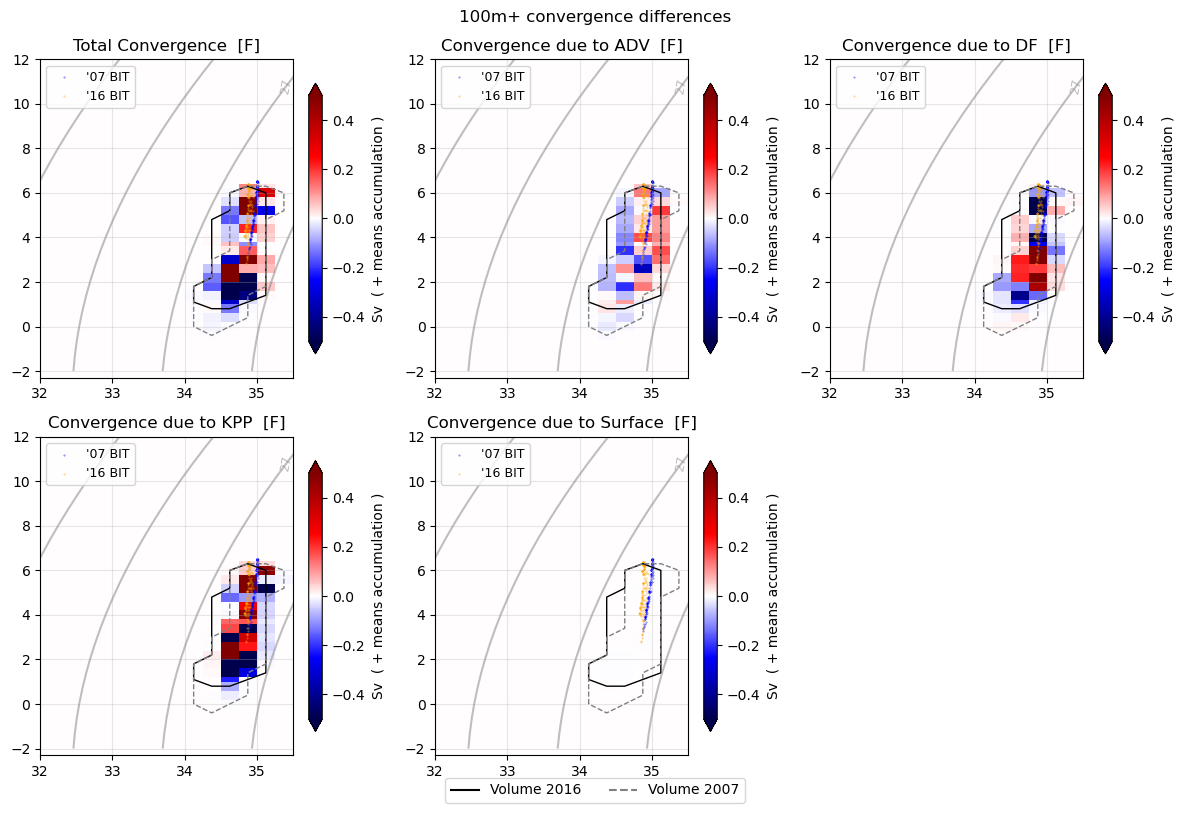

In [56]:
# Example: JFM indices
outpath, fig = plot_convergence_diff_for_idxs([1], sname="F", dlabel=100, scatter_size=0.6)
# outpath, fig = plot_convergence_diff_for_idxs([10], sname="O", dlabel=100, scatter_size=0.6)
print("Saved to:", outpath)

# Another season
# plot_convergence_diff_for_idxs([6,7,8], sname="JAS", dlabel=100, scatter_size=0.6)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_convergence_diff_DF_KPP_JFM(
    *,
    idxs_jfm=(0,1,2),           # Jan–Mar indices
    xlims=(32, 35.5),
    ylims=(-2.3, 12),
    vlev=0.5,
    scatter_size=1.0,
    scatter_alpha=0.6,
    fig_size=(10, 4.5),
    add_suptitle=True,
    close_fig=False,
    outdir=None,
    fname_prefix="convergence_diff_DF_KPP",
    dlabel=None,
    sname="JFM"
):
    """
    Plot JFM-mean 2016-2007 convergence differences in T–S space for DF and KPP only.
    Uses same globals as your original function:
      JtermsS_nn_all_2016/2007 : (t, 5, nS, nT)
      JtermsT_nn_all_2016/2007 : (t, 5, nS, nT)
      vol_mesh_all_2016/2007   : (t, nS, nT)
      Sbin, Tbin               : 1D bin edges/centers (used with shading='auto')
      Sbincent, Tbincent       : 2D centers for contouring volumes
      si, ti, dens2            : for density contours
      theta_timeseries/salt_timeseries['BSO'] : (2 years, 12 months, depth, gate)
      a, b, d_sel              : gate/Depth selection
      path (optional)          : default output directory
    """
    if outdir is None:
        outdir = locals().get("path", ".")

    # --- JFM means over requested timesteps ---
    JS16 = np.nanmean(JtermsS_nn_all_2016[idxs_jfm, ...], axis=0)  # (5, nS, nT)
    JT16 = np.nanmean(JtermsT_nn_all_2016[idxs_jfm, ...], axis=0)
    JS07 = np.nanmean(JtermsS_nn_all_2007[idxs_jfm, ...], axis=0)
    JT07 = np.nanmean(JtermsT_nn_all_2007[idxs_jfm, ...], axis=0)

    VOL16 = np.nanmean(vol_mesh_all_2016[idxs_jfm, ...], axis=0)   # (nS, nT)
    VOL07 = np.nanmean(vol_mesh_all_2007[idxs_jfm, ...], axis=0)

    # --- BSO inflow samples for these timesteps (scatter) ---
    thetas = theta_timeseries['BSO'][:, idxs_jfm, :, :]  # (2, len(idxs), depth, gate)
    salts  =  salt_timeseries['BSO'][:, idxs_jfm, :, :]
    theta_07_sample = thetas[0, :, d_sel:, a:b].reshape(-1)
    salt_07_sample  =  salts[0,  :, d_sel:, a:b].reshape(-1)
    theta_16_sample = thetas[1, :, d_sel:, a:b].reshape(-1)
    salt_16_sample  =  salts[1,  :, d_sel:, a:b].reshape(-1)

    # Which term indices? Based on your titles order:
    # 0=Total, 1=ADV, 2=DF, 3=KPP, 4=Surface
    term_indices = [2, 3]
    term_names   = ["Convergence due to DF", "Convergence due to KPP"]

    fig, axes = plt.subplots(1, 2, figsize=fig_size)
    for ax, term_i, tname in zip(axes, term_indices, term_names):
        # convergence (negative divergence) and diff
        div16 = np.gradient(JS16[term_i], axis=0) + np.gradient(JT16[term_i], axis=1)
        div07 = np.gradient(JS07[term_i], axis=0) + np.gradient(JT07[term_i], axis=1)
        diff  = -(div16 - div07)  # conv16 - conv07

        pcm = ax.pcolormesh(Sbin, Tbin, diff, cmap="seismic",
                            vmin=-vlev, vmax=+vlev, shading="auto")
        cb = fig.colorbar(pcm, ax=ax, shrink=0.9, extend="both")
        cb.set_label("Sv  ( + means accumulation )")

        # Volume outlines: solid=2016, dashed=2007
        ax.contour(Sbincent, Tbincent, VOL16, levels=[0.1], colors="k", linewidths=1.0)
        ax.contour(Sbincent, Tbincent, VOL07, levels=[0.1], colors="grey",
                   linestyles="--", linewidths=1.0)

        # Gate scatter
        sc07 = ax.scatter(salt_07_sample, theta_07_sample, marker=".", s=scatter_size,
                          color="blue", alpha=scatter_alpha, rasterized=True, label="'07 BIT")
        sc16 = ax.scatter(salt_16_sample, theta_16_sample, marker=".", s=scatter_size,
                          color="orange", alpha=scatter_alpha, rasterized=True, label="'16 BIT")
        ax.legend(handles=[sc07, sc16], loc="upper left", fontsize=9, frameon=True)

        # Density contours
        cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5,
                        levels=np.arange(16, 32, 1))
        ax.clabel(cs, fontsize=9, inline=False, fmt="%.0f")

        ax.set_title(f"{tname}  [{sname}]")
        ax.set_xlim(xlims); ax.set_ylim(ylims)
        ax.grid(True, alpha=0.3)

    # Figure-level legend for volume outlines
    proxies = [
        Line2D([0], [0], color="k", lw=1.5, label="Volume 2016"),
        Line2D([0], [0], color="grey", lw=1.5, ls="--", label="Volume 2007"),
    ]
    fig.legend(handles=proxies, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.04))

    if add_suptitle:
        prefix = f"{dlabel}m+ " if dlabel is not None else ""
        plt.suptitle(f"{prefix}Convergence differences (2016–2007), DF & KPP [{sname}]")

    plt.tight_layout()

    # Save
    outname = f"{outdir}/{fname_prefix}_{sname}_DF_KPP.png"
    fig.savefig(outname, dpi=200, bbox_inches="tight")
    if close_fig:
        plt.close(fig)

    return outname, fig


Saved to: ./convergence_diff_DF_KPP_JFM_DF_KPP.png


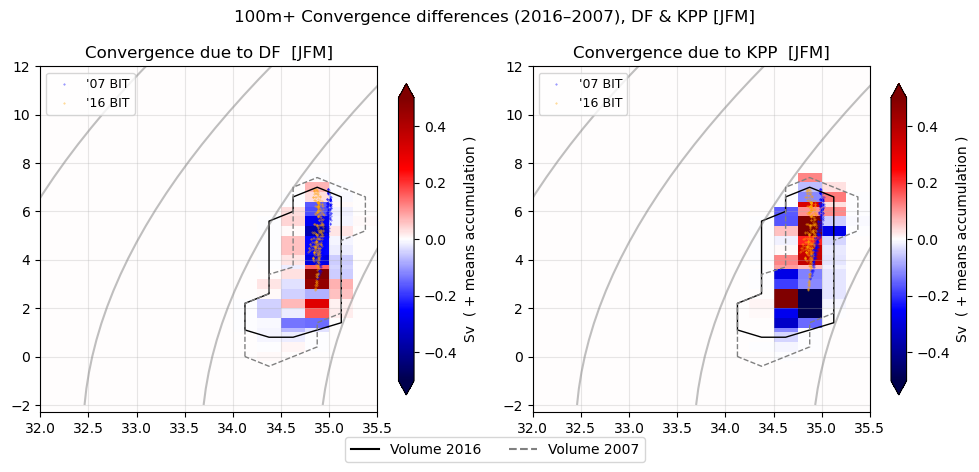

In [59]:
outpath, fig = plot_convergence_diff_DF_KPP_JFM(
    idxs_jfm=(0,1),   # Jan–Mar
    sname="JFM",
    dlabel=100,
    scatter_size=0.6
)
print("Saved to:", outpath)


## Load the profiles -- are these different and would this explain the stratification changes for the two years

In [50]:
# how is the stratification different in profiles for these two years?
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(mymsk[np.newaxis,:,:],(50,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(mymsk[np.newaxis,:,:],(50,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz

    iy += 1

2007
2016


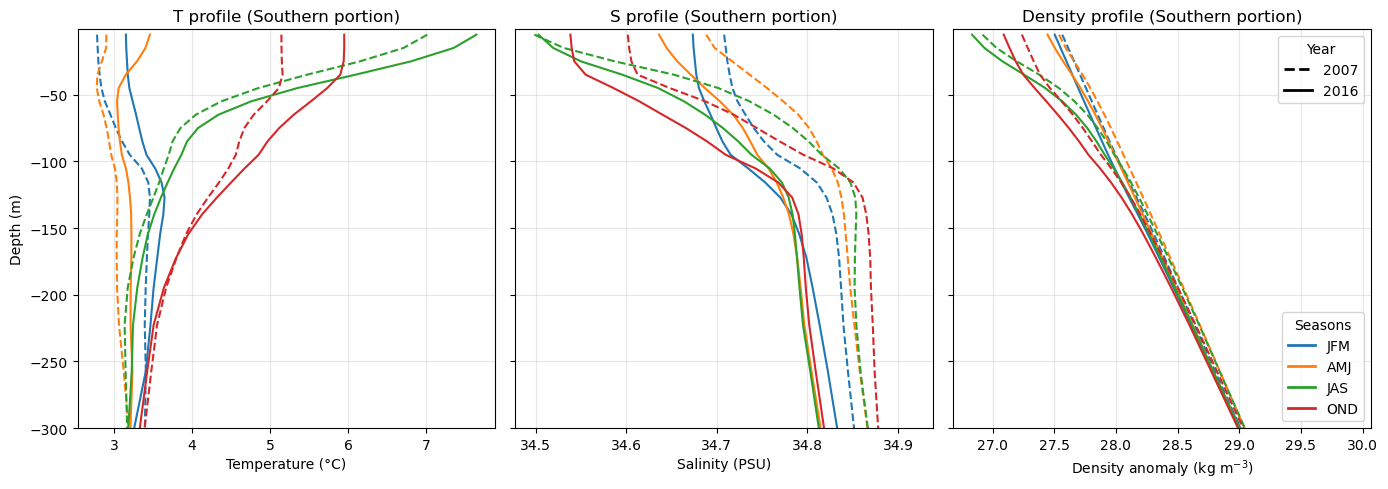

In [56]:
RC = mygrid['RC']  # depth array, length 50

# Define seasons and colors
seasons = [
    ("JFM", [0, 1, 2],   "C0"),
    ("AMJ", [3, 4, 5],   "C1"),
    ("JAS", [6, 7, 8],   "C2"),
    ("OND", [9, 10, 11], "C3"),
]

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
axT, axS, axR = axes

for name, mids, color in seasons:
    # --- seasonal means ---
    th07 = np.nanmean(theta_dist1[0, mids, :], axis=0)
    th16 = np.nanmean(theta_dist1[1, mids, :], axis=0)
    sa07 = np.nanmean(salt_dist1[0, mids, :],  axis=0)
    sa16 = np.nanmean(salt_dist1[1, mids, :],  axis=0)

    # --- convert to density ---
    # pressure from depth (positive downward)
    pres = gsw.p_from_z(RC, lat=75)   # adjust latitude if needed
    rho07 = gsw.rho(sa07, th07, pres)
    rho16 = gsw.rho(sa16, th16, pres)

    # --- plots ---
    axT.plot(th07, RC, ls="--", color=color)
    axT.plot(th16, RC, ls="-",  color=color)

    axS.plot(sa07, RC, ls="--", color=color)
    axS.plot(sa16, RC, ls="-",  color=color)

    axR.plot(rho07-1000, RC, ls="--", color=color)
    axR.plot(rho16-1000, RC, ls="-",  color=color)

# Axes cosmetics
for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-300, -1)   # adjust as needed

axT.set_title("T profile (Southern portion)")
axS.set_title("S profile (Southern portion)")
axR.set_title("Density profile (Southern portion)")

axT.set_xlabel("Temperature (°C)")
axS.set_xlabel("Salinity (PSU)")
axR.set_xlabel("Density anomaly (kg m$^{-3}$)")
axT.set_ylabel("Depth (m)")

# Legends: colors → seasons, linestyles → years
season_handles = [Line2D([0],[0], color=c, lw=2, label=n) for n, _, c in seasons]
year_handles   = [
    Line2D([0],[0], color="k", lw=2, ls="--", label="2007"),
    Line2D([0],[0], color="k", lw=2, ls="-",  label="2016"),
]

# Put both legends on the rightmost panel
leg1 = axR.legend(handles=season_handles, title="Seasons", loc="lower right")
axR.add_artist(leg1)
axR.legend(handles=year_handles, title="Year", loc="upper right")

plt.tight_layout()
plt.show()


## Let's create a profile (comparison) of just the average of the KPP term for the two years so that we try to understand it

In [70]:
# let's do a 2x2 which is the difference in BSO T and BSO S and also the avg profile differences in T and S for this region

# do this by looping through the salt and heat -- we want to make an average of these as depth
# ArcWater = np.zeros((ntimes,nz,ny,nx))   # file to store True/False Arctic Water exists as a mask
# save the average T and S profiles with depth
ntimes = 12*2
kppthetaprofile = np.zeros((nz,ntimes))
kppsaltprofile = np.zeros((nz,ntimes))

# do indexing in years for the layers
iy = 0
allyears = np.array([2007,2016])
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_kpptend_set1'
        meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
        varnames = np.array(["KPPg_TH","KPPg_SLT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        kppTHETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        kppSALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        kppTHETADR = np.reshape(kppTHETADRi,(nz,ny,nx))
        kppSALTDR = np.reshape(kppSALTDRi,(nz,ny,nx))

        thisTHETA = kppTHETADR * mymsk[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution

        # do the depth averaging for freshwater
        thisSALT = kppSALTDR * mymsk[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan

        kppthetaprofile[:,iy] = np.nanmean(thisTHETA,axis=(1,2))
        kppsaltprofile[:,iy] = np.nanmean(thisSALT,axis=(1,2))

        iy +=1

2007
2016


Text(0, 0.5, 'Depth (m)')

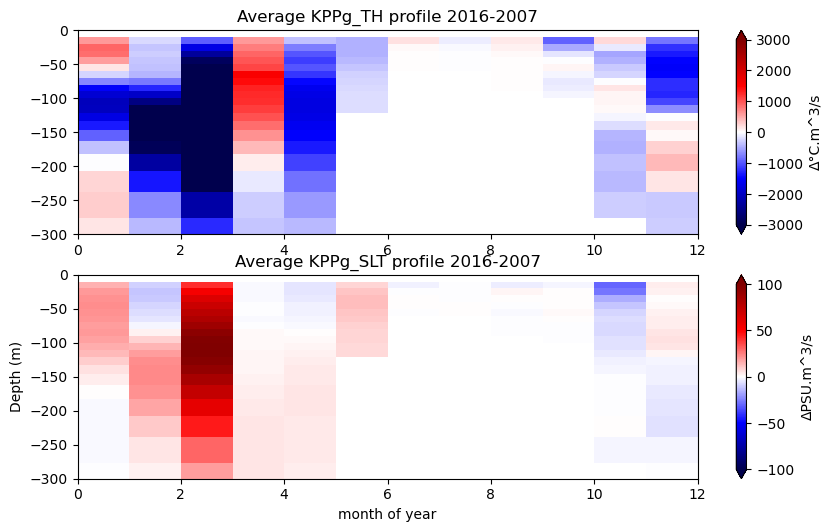

In [76]:
# try to add these as a plot
fig = plt.figure(figsize=(10,9))
XVc,YVc = np.meshgrid(np.arange(13),mygrid['RF'])


# temperature profile average
ax = plt.subplot(311)
cb = ax.pcolormesh(XVc, YVc, kppthetaprofile[:,12:] - kppthetaprofile[:,:12],cmap='seismic',vmin=-3000,vmax=3000)
# cs = ax.contour(XVc1, YVc1, theta_mean, colors='k', linewidths=0.8,levels = np.arange(1,8,.5))
ax.clabel(cs, fmt="%.1f")
ax.set_ylim(-300,0)
ax.set_title("Average KPPg_TH profile 2016-2007")
plt.colorbar(cb,extend="both",label="Δ°C.m^3/s")

# salt profile average
ax = plt.subplot(312)
cb = ax.pcolormesh(XVc, YVc, kppsaltprofile[:,12:] - kppsaltprofile[:,:12],cmap='seismic',vmin=-100,vmax=100)
# cs = ax.contour(XVc1, YVc1, salt_mean, colors='k', linewidths=0.8,levels = np.arange(34.5,35,.1))
ax.clabel(cs, fmt="%.2f")
ax.set_ylim(-300,0)
ax.set_title("Average KPPg_SLT profile 2016-2007")
plt.colorbar(cb,extend="both",label="ΔPSU.m^3/s")

plt.xlabel("month of year")
plt.ylabel("Depth (m)")